## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping dataset .zip file into 'dataset' folder

In [2]:
cd /content

/content


In [3]:
!mkdir dataset

In [ ]:
# Takes 1-2 mins
!unzip drive/MyDrive/5554/Plant_leaf_diseases_dataset_with_augmentation.zip -d /content/dataset/

## Installing and importing required packages

In [5]:
!pip install pyfeats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 52.4 MB/s 
  Created wheel for pyfeats: filename=pyfeats-1.0.0-py3-none-any.whl size=49741 sha256=904806f04000edf1fc2f6dc1a206415fca7a936bd161c36501be014135897cd1
  Stored in directory: /root/.cache/pip/wheels/fc/18/b5/cb0a301584251bf4d4e8678a2a6996897df5129c47708c14de
Successfully built pyfeats


In [6]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pathlib
import cv2
import random
import shutil
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import mahotas
import pyfeats
import h5py
import warnings
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

## Getting names of all subfolders and storing them in variables for indexing and referencing purposes

In [9]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)

dataset_index = {}

for folder in folders:
  split = folder.split("__")

  if len(split) < 2:
    continue

  leaf_type = split[0].replace(",", "")
  
  if leaf_type in dataset_index.keys():
    dataset_index[leaf_type].append(folder)
  else:
    dataset_index[leaf_type] = [folder]

dataset_index

{'Grape': ['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___Esca_(Black_Measles)',
  'Grape___Black_rot',
  'Grape___healthy'],
 'Potato': ['Potato___healthy',
  'Potato___Early_blight',
  'Potato___Late_blight'],
 'Corn': ['Corn___Common_rust',
  'Corn___healthy',
  'Corn___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn___Northern_Leaf_Blight'],
 'Orange': ['Orange___Haunglongbing_(Citrus_greening)'],
 'Soybean': ['Soybean___healthy'],
 'Apple': ['Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Apple_scab'],
 'Tomato': ['Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Late_blight',
  'Tomato___Septoria_leaf_spot',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___Leaf_Mold',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Target_Spot',
  'Tomato___Early_blight',
  'Tomato___Bacterial_spot',
  'Tomato___healthy'],
 'Raspberry': ['Raspberry___healthy'],
 'Cherry': ['Cherry___Powdery_mildew', 'Cherry___healthy'],
 'Pepper_bell': ['

In [10]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)
type_of_leaves = {}

for folder in folders:
  leaf_type = folder.split("_")[0].replace(",", "")
  #print("Leaf Type: {}".format(leaf_type))
  variation = " ".join(folder.split("_")[1:]).strip()
  #print("Variation: {}".format(variation))
  if leaf_type in type_of_leaves.keys():
    type_of_leaves[leaf_type].append(variation)
  else:
    type_of_leaves[leaf_type] = [variation]

type_of_leaves

{'Grape': ['Leaf blight (Isariopsis Leaf Spot)',
  'Esca (Black Measles)',
  'Black rot',
  'healthy'],
 'Potato': ['healthy', 'Early blight', 'Late blight'],
 'Corn': ['Common rust',
  'healthy',
  'Cercospora leaf spot Gray leaf spot',
  'Northern Leaf Blight'],
 'Orange': ['Haunglongbing (Citrus greening)'],
 'Soybean': ['healthy'],
 'Apple': ['Cedar apple rust', 'healthy', 'Black rot', 'Apple scab'],
 'Tomato': ['Tomato Yellow Leaf Curl Virus',
  'Late blight',
  'Septoria leaf spot',
  'Tomato mosaic virus',
  'Leaf Mold',
  'Spider mites Two-spotted spider mite',
  'Target Spot',
  'Early blight',
  'Bacterial spot',
  'healthy'],
 'Background': ['without leaves'],
 'Raspberry': ['healthy'],
 'Cherry': ['Powdery mildew', 'healthy'],
 'Pepper': ['bell   healthy', 'bell   Bacterial spot'],
 'Squash': ['Powdery mildew'],
 'Blueberry': ['healthy'],
 'Strawberry': ['healthy', 'Leaf scorch'],
 'Peach': ['healthy', 'Bacterial spot']}

In [11]:
# eligible types of classification based on data
eligible_types = ['Pepper', 'Tomato', 'Corn', 'Grape', 'Apple', 'Strawberry', 'Peach', 'Cherry', 'Potato']

In [12]:
# view stats for an eligible type

eligible_type = "Cherry"
subset_of_folders = []
for folder in folders:
  if eligible_type in folder:
    subset_of_folders.append(folder)

count_healthy_leaves = 0
count_diseased_leaves = 0

for subset_folder in subset_of_folders:
  if "healthy" in subset_folder:
    count_healthy_leaves = len(os.listdir(dataset_path + subset_folder + "/"))
  else:
    count_diseased_leaves+= len(os.listdir(dataset_path + subset_folder + "/"))

print("For leaf type : {}".format(eligible_type))
print("No. of healthy leaves : {}".format(count_healthy_leaves))
print("No. of diseased leaves : {}".format(count_diseased_leaves))

For leaf type : Cherry
No. of healthy leaves : 1000
No. of diseased leaves : 1052


In [13]:
eligible_types_stats = {}

for eligible_type in eligible_types:

  subset_of_folders = []
  for folder in folders:
    if eligible_type in folder:
      subset_of_folders.append(folder)

  # getting subsets properly, checked manually for each eligible type
  #subset_of_folders

  count_healthy_leaves = 0
  count_diseased_leaves = 0

  for subset_folder in subset_of_folders:
    if "healthy" in subset_folder:
      count_healthy_leaves = len(os.listdir(dataset_path + subset_folder + "/"))
    else:
      count_diseased_leaves+= len(os.listdir(dataset_path + subset_folder + "/"))

  eligible_types_stats[eligible_type] = "healthy: {} | diseased: {}".format(count_healthy_leaves, count_diseased_leaves)

eligible_types_stats

{'Pepper': 'healthy: 1478 | diseased: 1000',
 'Tomato': 'healthy: 1591 | diseased: 17244',
 'Corn': 'healthy: 1162 | diseased: 3192',
 'Grape': 'healthy: 1000 | diseased: 3639',
 'Apple': 'healthy: 1645 | diseased: 3000',
 'Strawberry': 'healthy: 1000 | diseased: 1109',
 'Peach': 'healthy: 1000 | diseased: 2297',
 'Cherry': 'healthy: 1000 | diseased: 1052',
 'Potato': 'healthy: 1000 | diseased: 2000'}

## Additional feature extraction

In [21]:
!pip install pyfeats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import pyfeats

In [23]:
def get_grayscale_image_and_roi_mask(eligible_type):
  # folder for chosen leaf type
  number_of_categories = len(dataset_index[eligible_type])
  folder_index = random.choice([i for i in range(number_of_categories)])

  # read image
  category = dataset_index[eligible_type][folder_index]
  path_to_folder = dataset_path + category + "/"
  random_image_number = random.randint(1, len(os.listdir(path_to_folder)))
  image_name = "image ({}).JPG".format(random_image_number)
  path = path_to_folder + image_name
  img = cv2.imread(path)
  
  #convert image to rgb & hsv
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

  #get grayscale image
  grayscale = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_BGR2RGB) 

  #create green/brown mask
  lower_green = np.array([25,0,20])
  upper_green = np.array([100,255,255])
  healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
  result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
  lower_brown = np.array([10,0,10])
  upper_brown = np.array([30,255,255])
  disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
  disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
  final_mask = healthy_mask + disease_mask

  return grayscale, final_mask

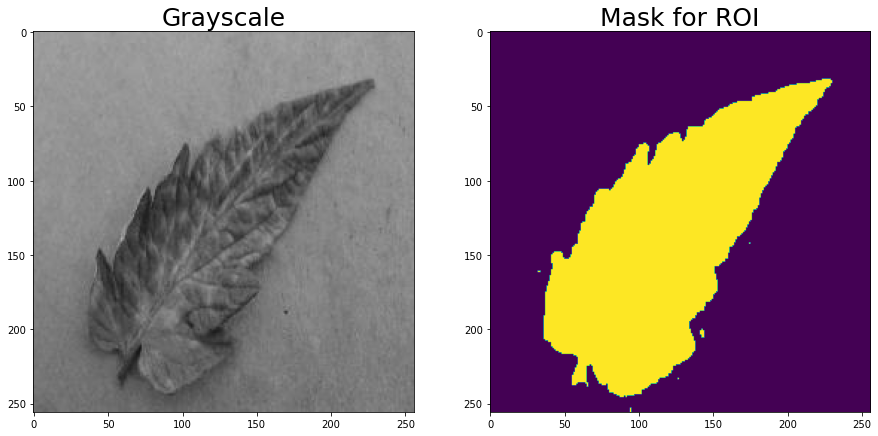

In [24]:
grayscale, mask = get_grayscale_image_and_roi_mask("Tomato")

plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plt.title("Grayscale", fontsize=25)
#plt.axis('off')
plt.imshow(grayscale)

plt.subplot(1, 2, 2)
plt.title("Mask for ROI", fontsize=25)
#plt.axis('off')
plt.imshow(mask)

plt.show()

In [25]:
#First Order Statistics/Statistical Features (FOS/SF)
features, labels = pyfeats.fos(grayscale[:,:,0], mask)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['FOS_Mean', 'FOS_Variance', 'FOS_Median', 'FOS_Mode', 'FOS_Skewness', 'FOS_Kurtosis', 'FOS_Energy', 'FOS_Entropy', 'FOS_MinimalGrayLevel', 'FOS_MaximalGrayLevel', 'FOS_CoefficientOfVariation', 'FOS_10Percentile', 'FOS_25Percentile', 'FOS_75Percentile', 'FOS_90Percentile', 'FOS_HistogramWidth']
Features: [ 8.87927605e+01  4.43396087e+02  8.90000000e+01  9.50000000e+01
 -3.72358459e-02  2.79256938e+00  1.34689491e-02  4.47012357e+00
  2.10000000e+01  1.77000000e+02  1.06247188e-01  6.10000000e+01
  7.40000000e+01  1.03000000e+02  1.15000000e+02  5.40000000e+01]


In [26]:
# Gray Level Co-occurence Matrix (GLCM/SGLDM)
features_mean, features_range, labels_mean, labels_range = pyfeats.glcm_features(grayscale[:,:,0], ignore_zeros=True)
print("Labels Mean : {}".format(labels_mean))
print("Features Mean : {}".format(features_mean))
print("Labels Range : {}".format(labels_range))
print("Features Range : {}".format(features_range))

Labels Mean : ['GLCM_ASM_Mean', 'GLCM_Contrast_Mean', 'GLCM_Correlation_Mean', 'GLCM_SumOfSquaresVariance_Mean', 'GLCM_InverseDifferenceMoment_Mean', 'GLCM_SumAverage_Mean', 'GLCM_SumVariance_Mean', 'GLCM_SumEntropy_Mean', 'GLCM_Entropy_Mean', 'GLCM_DifferenceVariance_Mean', 'GLCM_DifferenceEntropy_Mean', 'GLCM_Information1_Mean', 'GLCM_Information2_Mean', 'GLCM_MaximalCorrelationCoefficient_Mean']
Features Mean : [ 1.08265780e-03  4.61645858e+01  9.70037098e-01  7.70201271e+02
  2.79363511e-01  2.43675465e+02  3.03464050e+03  7.56923991e+00
  1.08300525e+01  6.33831774e-04  3.59930498e+00 -3.55414552e-01
  9.94886548e-01  4.69588176e+00]
Labels Range : ['GLCM_ASM_Range', 'GLCM_Contrast_Range', 'GLCM_Correlation_Range', 'GLCM_SumOfSquaresVariance_Range', 'GLCM_InverseDifferenceMoment_Range', 'GLCM_SumAverage_Range', 'GLCM_SumVariance_Range', 'GLCM_SumEntropy_Range', 'GLCM_Entropy_Range', 'GLCM_DifferenceVariance_Range', 'GLCM_DifferenceEntropy_Range', 'GLCM_Information1_Range', 'GLCM_I

In [27]:
# Gray Level Difference Statistics (GLDS)
features, labels = pyfeats.glds_features(grayscale[:,:,0], mask, Dx=[0,1,1,1], Dy=[1,1,0,-1])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GLDS_Homogeneity', 'GLDS_Contrast', 'GLDS_ASM', 'GLDS_Entopy', 'GLDS_Mean']
Features: [ 1.89050000e+04  0.00000000e+00  3.57399025e+08 -1.86160970e+05
  0.00000000e+00]


In [28]:
#Neighborhood Gray Tone Difference Matrix (NGTDM)
features, labels = pyfeats.ngtdm_features(grayscale[:,:,0], mask, d=1)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['NGTDM_Coarseness', 'NGTDM_Contrast', 'NGTDM_Busyness', 'NGTDM_Complexity', 'NGTDM_Strngth']
Features: [nan nan nan nan  0.]


In [29]:
#Statistical Feature Matrix (SFM)
features, labels = pyfeats.sfm_features(grayscale[:,:,0], mask, Lr=4, Lc=4)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['SFM_Coarseness', 'SFM_Contrast', 'SFM_Periodicity', 'SFM_Roughness']
Features: [7.04813902e+00 3.96865078e+03 5.79284389e-01 2.38366509e+00]


In [30]:
#Law's Texture Energy Measures (LTE/TEM)
features, labels = pyfeats.lte_measures(grayscale[:,:,0], mask, l=7)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['LTE_LL_7', 'LTE_EE_7', 'LTE_SS_7', 'LTE_LE_7', 'LTE_ES_7', 'LTE_LS_7']
Features: [nan nan nan nan nan nan]


In [31]:
#Fractal Dimension Texture Analysis (FDTA)
h, labels = pyfeats.fdta(grayscale[:,:,0], mask, s=3)
print("Labels: {}".format(labels))
print("Features: {}".format(h))

Labels: ['FDTA_HurstCoeff_1', 'FDTA_HurstCoeff_2', 'FDTA_HurstCoeff_3', 'FDTA_HurstCoeff_4']
Features: [       nan 0.31983759 0.2233608  0.20225262]


In [32]:
# Gray Level Run Length Matrix (GLRLM)
features, labels = pyfeats.glrlm_features(grayscale[:,:,0], mask, Ng=256)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GLRLM_ShortRunEmphasis', 'GLRLM_LongRunEmphasis', 'GLRLM_GrayLevelNo-Uniformity', 'GLRLM_RunLengthNonUniformity', 'GLRLM_RunPercentage', 'GLRLM_LowGrayLevelRunEmphasis', 'GLRLM_HighGrayLevelRunEmphasis', 'GLRLM_Short owGrayLevelEmphasis', 'GLRLM_ShortRunHighGrayLevelEmphasis', 'GLRLM_LongRunLowGrayLevelEmphasis', 'GLRLM_LongRunHighGrayLevelEmphasis']
Features: [9.16284120e-01 1.48823163e+00 6.76171890e+02 4.65416127e+04
 8.85543045e-01 9.11709856e-05 1.50565389e+04 8.52848178e-05
 1.35879076e+04 1.00000000e+00 2.39580729e+04]


In [34]:
# Gray Level Size Zone Matrix (GLSZM)
features, labels = pyfeats.glszm_features(grayscale[:,:,0], mask)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GLSZM_SmallZoneEmphasis', 'GLSZM_LargeZoneEmphasis', 'GLSZM_GrayLevelNonuniformity', 'GLSZM_ZoneSizeNonuniformity', 'GLSZM_ZonePercentage', 'GLSZM_LowGrayLeveLZoneEmphasis', 'GLSZM_HighGrayLevelZoneEmphasis', 'GLSZM_SmallZoneLowGrayLevelEmphasis', 'GLSZM_SmallZoneHighGrayLevelEmphasis', 'GLSZM_LargeZoneLowGrayLevelEmphassis', 'GLSZM_LargeZoneHighGrayLevelEmphasis', 'GLSZM_GrayLevelVariance', 'GLSZM_ZoneSizeVariance', 'GLSZM_ZoneSizeEntropy']
Features: [ 9.83762333e-01  6.38789340e+07  1.30809096e-02  9.67008310e-01
  1.75135222e+01  2.46431016e-04  8.66671047e+03  1.50339708e-04
  8.33050536e+03  4.11992964e+05  1.39466260e+12  6.42120350e-06
  2.23435369e-04 -6.58270990e+00]


In [35]:
# Higher Order Spectra (HOS)
features, labels = pyfeats.hos_features(grayscale[:,:,0], th=[135,140])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['HOS_135_degrees', 'HOS_140_degrees']
Features: [7.29636946 7.47222213]


In [36]:
#  Local Binary Pattern (LPB)
features, labels = pyfeats.lbp_features(grayscale[:,:,0], mask, P=[8,16,24], R=[1,2,3])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['LBP_R_1_P_8_energy', 'LBP_R_1_P_8_entropy', 'LBP_R_2_P_16_energy', 'LBP_R_2_P_16_entropy', 'LBP_R_3_P_24_energy', 'LBP_R_3_P_24_entropy']
Features: [ 5.78511236 -1.67289394 13.52604768 -2.53308081 21.89256323 -3.0350188 ]


In [37]:
# Gray-scale Morphological Analysis
pdf, cdf = pyfeats.grayscale_morphology_features(grayscale[:,:,0], N=30)
print("pdf: {}".format(pdf))
print("cdf: {}".format(cdf))

pdf: [0.01064025 0.01303727 0.01124022 0.00908387 0.00809267 0.00707231
 0.00649048 0.00608499 0.00552606 0.00454788 0.00411197 0.00342151
 0.00329449 0.0035364  0.00344379 0.00238651 0.00272017 0.00292153
 0.00206187 0.00246849 0.00316921 0.00310851 0.00356331 0.00520129
 0.00176176 0.00191394 0.00282692 0.00382438 0.0025173  0.00241642]
cdf: [0.01064025 0.02367752 0.03491775 0.04400161 0.05209428 0.05916658
 0.06565706 0.07174205 0.07726811 0.08181599 0.08592796 0.08934948
 0.09264396 0.09618037 0.09962416 0.10201067 0.10473084 0.10765237
 0.10971424 0.11218273 0.11535194 0.11846045 0.12202376 0.12722505
 0.12898681 0.13090075 0.13372767 0.13755205 0.14006934 0.14248576]


In [38]:
# Multilevel Binary Morphological Analysis
pdf_L, pdf_M, pdf_H, cdf_L, cdf_M, cdf_H = pyfeats.multilevel_binary_morphology_features(grayscale[:,:,0], mask, N=30, thresholds=[25, 50])
print("pdf_L: {}".format(pdf_L))
print("pdf_M: {}".format(pdf_M))
print("pdf_H: {}".format(pdf_H))
print("cdf_L: {}".format(cdf_L))
print("cdf_M: {}".format(cdf_M))
print("cdf_H: {}".format(cdf_H))

pdf_L: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
pdf_M: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
pdf_H: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
cdf_L: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
cdf_M: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
cdf_H: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


In [39]:
# Gabor Transform (GT)
features, labels = pyfeats.gt_features(grayscale[:,:,0], mask, deg=4, freq=[0.05, 0.4])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GT_th_0.0_freq_0.05_mean', 'GT_th_0.0_freq_0.05_std', 'GT_th_0.0_freq_0.4_mean', 'GT_th_0.0_freq_0.4_std', 'GT_th_1.0_freq_0.05_mean', 'GT_th_1.0_freq_0.05_std', 'GT_th_1.0_freq_0.4_mean', 'GT_th_1.0_freq_0.4_std', 'GT_th_2.0_freq_0.05_mean', 'GT_th_2.0_freq_0.05_std', 'GT_th_2.0_freq_0.4_mean', 'GT_th_2.0_freq_0.4_std', 'GT_th_3.0_freq_0.05_mean', 'GT_th_3.0_freq_0.05_std', 'GT_th_3.0_freq_0.4_mean', 'GT_th_3.0_freq_0.4_std']
Features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [40]:
# features, labels = zernikes_moments(f, radius=9)
features, labels = pyfeats.zernikes_moments(grayscale[:,:,0], radius=9)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['Zernikes_Moments_radius_9_0', 'Zernikes_Moments_radius_9_1', 'Zernikes_Moments_radius_9_2', 'Zernikes_Moments_radius_9_3', 'Zernikes_Moments_radius_9_4', 'Zernikes_Moments_radius_9_5', 'Zernikes_Moments_radius_9_6', 'Zernikes_Moments_radius_9_7', 'Zernikes_Moments_radius_9_8', 'Zernikes_Moments_radius_9_9', 'Zernikes_Moments_radius_9_10', 'Zernikes_Moments_radius_9_11', 'Zernikes_Moments_radius_9_12', 'Zernikes_Moments_radius_9_13', 'Zernikes_Moments_radius_9_14', 'Zernikes_Moments_radius_9_15', 'Zernikes_Moments_radius_9_16', 'Zernikes_Moments_radius_9_17', 'Zernikes_Moments_radius_9_18', 'Zernikes_Moments_radius_9_19', 'Zernikes_Moments_radius_9_20', 'Zernikes_Moments_radius_9_21', 'Zernikes_Moments_radius_9_22', 'Zernikes_Moments_radius_9_23', 'Zernikes_Moments_radius_9_24']
Features: [0.31830989 0.02753954 0.01628673 0.02846088 0.00459285 0.01327729
 0.02823978 0.0136767  0.03025722 0.02028345 0.02525107 0.01097891
 0.00169581 0.01226823 0.01291569 0.02120611 0.03325329 0

In [41]:
# Threshold Adjacency Matrix (TAS)
features, labels = pyfeats.tas_features(grayscale[:,:,0])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['TAS0', 'TAS1', 'TAS2', 'TAS3', 'TAS4', 'TAS5', 'TAS6', 'TAS7', 'TAS8', 'TAS9', 'TAS10', 'TAS11', 'TAS12', 'TAS13', 'TAS14', 'TAS15', 'TAS16', 'TAS17', 'TAS18', 'TAS19', 'TAS20', 'TAS21', 'TAS22', 'TAS23', 'TAS24', 'TAS25', 'TAS26', 'TAS27', 'TAS28', 'TAS29', 'TAS30', 'TAS31', 'TAS32', 'TAS33', 'TAS34', 'TAS35', 'TAS36', 'TAS37', 'TAS38', 'TAS39', 'TAS40', 'TAS41', 'TAS42', 'TAS43', 'TAS44', 'TAS45', 'TAS46', 'TAS47', 'TAS48', 'TAS49', 'TAS50', 'TAS51', 'TAS52', 'TAS53']
Features: [7.61184127e-01 7.17876739e-02 5.65012122e-02 4.92025010e-02
 2.80974863e-02 1.64603802e-02 8.88094934e-03 6.15031262e-03
 1.73535792e-03 8.24740201e-01 5.51675744e-02 4.29712300e-02
 3.53526915e-02 1.97480536e-02 1.02582952e-02 6.21512347e-03
 4.27707421e-03 1.26975641e-03 8.98491950e-01 3.45321645e-02
 2.41142330e-02 1.83588722e-02 1.10007528e-02 6.53245586e-03
 3.86119138e-03 2.40413803e-03 7.04242454e-04 6.63693977e-01
 9.13817312e-02 7.63158893e-02 6.94470798e-02 4.35657091e-02
 2.72475428e-02 1

In [42]:
#  Histogram of Oriented Gradients (HOG)
fd, labels = pyfeats.hog_features(grayscale[:,:,0], ppc=8, cpb=3)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['HOS_ppc_8_cpb3_0', 'HOS_ppc_8_cpb3_1', 'HOS_ppc_8_cpb3_2', 'HOS_ppc_8_cpb3_3', 'HOS_ppc_8_cpb3_4', 'HOS_ppc_8_cpb3_5', 'HOS_ppc_8_cpb3_6', 'HOS_ppc_8_cpb3_7', 'HOS_ppc_8_cpb3_8', 'HOS_ppc_8_cpb3_9', 'HOS_ppc_8_cpb3_10', 'HOS_ppc_8_cpb3_11', 'HOS_ppc_8_cpb3_12', 'HOS_ppc_8_cpb3_13', 'HOS_ppc_8_cpb3_14', 'HOS_ppc_8_cpb3_15', 'HOS_ppc_8_cpb3_16', 'HOS_ppc_8_cpb3_17', 'HOS_ppc_8_cpb3_18', 'HOS_ppc_8_cpb3_19', 'HOS_ppc_8_cpb3_20', 'HOS_ppc_8_cpb3_21', 'HOS_ppc_8_cpb3_22', 'HOS_ppc_8_cpb3_23', 'HOS_ppc_8_cpb3_24', 'HOS_ppc_8_cpb3_25', 'HOS_ppc_8_cpb3_26', 'HOS_ppc_8_cpb3_27', 'HOS_ppc_8_cpb3_28', 'HOS_ppc_8_cpb3_29', 'HOS_ppc_8_cpb3_30', 'HOS_ppc_8_cpb3_31', 'HOS_ppc_8_cpb3_32', 'HOS_ppc_8_cpb3_33', 'HOS_ppc_8_cpb3_34', 'HOS_ppc_8_cpb3_35', 'HOS_ppc_8_cpb3_36', 'HOS_ppc_8_cpb3_37', 'HOS_ppc_8_cpb3_38', 'HOS_ppc_8_cpb3_39', 'HOS_ppc_8_cpb3_40', 'HOS_ppc_8_cpb3_41', 'HOS_ppc_8_cpb3_42', 'HOS_ppc_8_cpb3_43', 'HOS_ppc_8_cpb3_44', 'HOS_ppc_8_cpb3_45', 'HOS_ppc_8_cpb3_46', 'HOS_ppc_8_cpb

## Creating curated dataset for classification for a specific leaf type

In [43]:
# creating folder structure for specific eligible type of leaf
eligible_type = "Apple"

base_path = "/content/"
curated_dataset = "curated_dataset/" 
classes = ["healthy", "diseased"]

for c in classes:
  path = base_path + curated_dataset + eligible_type + "/" + c + "/"
  p = pathlib.Path(path)
  p.mkdir(parents=True, exist_ok=True)

In [44]:
# copying images from source subfolders to destination class folders ("healthy" & "diseased") for a specific eligible type of leaf

eligible_type = "Apple"

# source
source_dataset = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
source_folders = dataset_index[eligible_type]

# destination
destination_dataset = "/content/curated_dataset/{}/".format(eligible_type)
classes = ["healthy", "diseased"]
healthy_count = 0
diseased_count = 0

for source_folder in tqdm(source_folders):
  source_path = source_dataset +  source_folder + "/"
  source_image_list = os.listdir(source_path)
  for i in range(len(source_image_list)):
    source_image = source_image_list[i]
    source = source_path + source_image
    if "healthy" in source_folder:
      healthy_count+=1
      destination = destination_dataset + classes[0] + "/{}.jpg".format(healthy_count)
    else:
      diseased_count+=1
      destination = destination_dataset + classes[1] + "/{}.jpg".format(diseased_count)
    shutil.copyfile(source, destination)

100%|██████████| 4/4 [00:00<00:00,  9.39it/s]


In [45]:
# verifying copied images in terms of counts in the destination folders

# check if this count matches with the count for leaf type in stats output

print("For leaf type : {}".format(eligible_type))
print("No. of healthy leaves : {}".format(len(os.listdir(destination_dataset + classes[0]+"/"))))
print("No. of diseased leaves : {}".format(len(os.listdir(destination_dataset + classes[1]+"/"))))

For leaf type : Apple
No. of healthy leaves : 1645
No. of diseased leaves : 3000


## Data Pre-processing

In [46]:
images_per_class = 800
fixed_size = tuple((500, 500))
mask = np.ones(fixed_size)
train_path = '/content/curated_dataset/' + eligible_type + '/'
# h5_train_data = '/content/curated_dataset/Apple/output/train_data.h5'
# h5_train_labels = '/content/curated_dataset/Apple/output/train_labels.h5'
bins = 8

In [47]:
def bgr2rgb(image):
  rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return rgb_img

def rgb2hsv(rgb_img):
  hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
  return hsv_img

def img_segmentation(rgb_img,hsv_img):
  l_g = np.array([25,0,20])
  u_g = np.array([100,255,255])
  h_mask = cv2.inRange(hsv_img, l_g, u_g)
  result = cv2.bitwise_and(rgb_img,rgb_img, mask=h_mask)
  
  l_b = np.array([10,0,10])
  u_b = np.array([30,255,255])
  d_mask = cv2.inRange(hsv_img, l_b, u_b)
  d_result = cv2.bitwise_and(rgb_img, rgb_img, mask=d_mask)
  
  final_mask = h_mask + d_mask
  final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
  
  return final_result

def zernikes_moments_features(grayscale_image):
  zernikes_moments_features, labels = pyfeats.zernikes_moments(grayscale_image, radius=9)
  return zernikes_moments_features

def haralick_features(grayscale_image):
  haralick = mahotas.features.haralick(grayscale_image).mean(axis=0)
  return haralick

def histogram_features(image, mask=None):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hist  = cv2.calcHist([hsv_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
  cv2.normalize(hist, hist)
  return hist.flatten()

In [48]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

['diseased', 'healthy']


In [49]:
for training_name in train_labels:
    image_folder_path = os.path.join(train_path, training_name)
    current_label = training_name

    for idx in tqdm(range(1,images_per_class+1)):
        image_path = image_folder_path + "/" + str(idx) + ".jpg"
        image_bgr = cv2.imread(image_path)
        image_bgr = cv2.resize(image_bgr, fixed_size)

        image_rgb = bgr2rgb(image_bgr)
        image_hsv = rgb2hsv(image_rgb)
        image_segmented = img_segmentation(image_rgb,image_hsv)
        grayscale_image = cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY)

        hist_features = histogram_features(image_segmented)
        zernikes_features = zernikes_moments_features(grayscale_image)
        har_features = haralick_features(grayscale_image)
        
        global_feature = np.hstack([zernikes_features,hist_features,har_features])

        labels.append(current_label)
        global_features.append(global_feature)

100%|██████████| 800/800 [00:42<00:00, 19.02it/s]


In [50]:
properties =  'imsize='+str(fixed_size[0]) +'x'+str(fixed_size[0]) + \
              '_'+'perclsimgs=' + str(images_per_class) + \
              '_clsnum=' + str(len(classes)) +\
              '_leaftype='+eligible_type

In [51]:
properties

'imsize=500x500_perclsimgs=800_clsnum=2_leaftype=Apple'

In [52]:
global_features_filename = 'globalfeatures' + '_' + properties + '.pkl'
labels_filename = 'labels' + '_' + properties + '.pkl'

print('Global Features save filename: {}'.format(global_features_filename))
print('Labels save filename: {}'.format(labels_filename))

Global Features save filename: globalfeatures_imsize=500x500_perclsimgs=800_clsnum=2_leaftype=Apple.pkl
Labels save filename: labels_imsize=500x500_perclsimgs=800_clsnum=2_leaftype=Apple.pkl


In [53]:
with open(global_features_filename, 'wb') as fp:
  pickle.dump(global_features, fp)

with open(labels_filename, 'wb') as fp:
  pickle.dump(labels, fp)

## ML Model Experimentation 

In [54]:
saved_gf_path = "/content/globalfeatures_imsize=500x500_perclsimgs=800_clsnum=2_leaftype=Apple.pkl"
saved_label_path = "/content/labels_imsize=500x500_perclsimgs=800_clsnum=2_leaftype=Apple.pkl"

with open(saved_gf_path, 'rb') as file:
  global_features = pickle.load(file)

with open(saved_label_path, 'rb') as file:
  labels = pickle.load(file)

In [57]:
# shape of the feature vector and labels
print("Gloabl features shape: {}".format(np.array(global_features).shape))
print("Labels shape: {}".format(np.array(labels).shape))

Gloabl features shape: (1600, 550)
Labels shape: (1600,)


In [58]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import shuffle
from 

In [59]:
num_trees = 100
test_size = 0.20
seed      = 100
train_path = "/content/curated_dataset/Apple/"
test_path  = "/content/curated_dataset/Apple/test"
scoring    = "accuracy"

In [64]:
models = [('Logistic Regression', LogisticRegression(random_state=seed)), ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()), ('K Nearest Neighbors', KNeighborsClassifier()), ('CART', DecisionTreeClassifier(random_state=seed)), ('Random Forest', RandomForestClassifier(n_estimators=num_trees, random_state=seed)), ('Naive Bayes', GaussianNB()), ('XGBoost', XGBClassifier(max_depth=3)), ('Support Vector Machine', SVC(random_state=seed))]

In [65]:
model_results = []
model_names   = []

In [66]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1280, 550)
Test data   : (320, 550)


In [67]:
# 10-fold cross validation
for model_name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    model_results.append(results)
    model_names.append(model_name)
    print("For {} : Mean Accuracy is {} & Standard Deviation is {}".format(model_name, results.mean(), results.std()))

For Logistic Regression : Mean Accuracy is 0.940625 & Standard Deviation is 0.029481191037676886
For Linear Discriminant Analysis : Mean Accuracy is 0.98671875 & Standard Deviation is 0.007851465329000695
For K Nearest Neighbors : Mean Accuracy is 0.81796875 & Standard Deviation is 0.02986174195877561
For CART : Mean Accuracy is 0.99453125 & Standard Deviation is 0.00703125
For Random Forest : Mean Accuracy is 0.9984375 & Standard Deviation is 0.0046875
For Naive Bayes : Mean Accuracy is 0.834375 & Standard Deviation is 0.035596205468420364
For XGBoost : Mean Accuracy is 0.99921875 & Standard Deviation is 0.0023437500000000003
For Support Vector Machine : Mean Accuracy is 0.64609375 & Standard Deviation is 0.03494729569741413
